In [ ]:
# Check the allocated GPU info on Google Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Nov 17 08:53:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import statements
!pip install pickle5
!pip install efficientnet
import pickle5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dropout, Dense
from efficientnet.tfkeras import EfficientNetB5 
from sklearn.model_selection import train_test_split

In [ ]:
NUM_CLASSES = 2

# Allows querying the physical hardware resources prior to runtime initialization
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Hyperparameters
epochs1 = 10
epochs2 = 30
lr1 = 1e-2
lr2 = 1e-4
dr = 0.2
batch_size = 16
ori_size = 256
img_size = 227
img_channels = 3
img_dims = (img_size, img_size, img_channels)
base_path = "drive/My Drive/CE4042 : Neural Network & Deep Learning/Project/"
dataset_prefix = "dataset/"
results_prefix = "results/"

# TOCHANGE
fold = 4
bag = 2

In [ ]:
# Function to load train & test datasets from the pickle files
def load_file(filename):
    with open(filename + '.pkl', 'rb') as serialized_file:
        return pickle5.load(serialized_file)

In [ ]:
# Build model using EfficientNetB5 as backbone
efficient = EfficientNetB5(weights='imagenet',
                           include_top=False,
                           input_shape=img_dims)

# Freeze the pre-trained weights initially to train the added layers first
efficient.trainable = False  

# Add additional pooling and dropout layers to the model
model = Sequential()
model.add(efficient)
model.add(GlobalMaxPooling2D())
if dr > 0:
    model.add(Dropout(dr))

# Output layer neuron count == NUM_CLASS if activation == 'softmax'
# Else count == 1 (for binary classifier -> sigmoid)
model.add(Dense(1, activation='sigmoid'))

115515392/115515256 [==============================] - 4s 0us/step


In [ ]:
# Load the serialized data from our drive
# Refer to gender_preprocessing.ipynb for details on how these are generated
train_file = load_file(base_path + dataset_prefix + f'cv_fold_{fold}_train_subset')
val_file = load_file(base_path + dataset_prefix + f'cv_fold_{fold}_val')

# Load images and labels from the deserialized object
train_images = np.array(train_file['images'])
train_genders = np.array(train_file['genders'])

val_images = np.array(val_file['images'])
val_genders = np.array(val_file['genders'])

print(f"Details of train & validation datasets for fold no. {fold}")
print(train_images.shape)
print(train_genders.shape)
print(val_images.shape)
print(val_genders.shape)

X_train = train_images
y_train = train_genders

X_val = val_images
y_val = val_genders

Details of train & validation datasets for fold no. 3
(11406, 256, 256, 3)
(11406,)
(2642, 256, 256, 3)
(2642,)


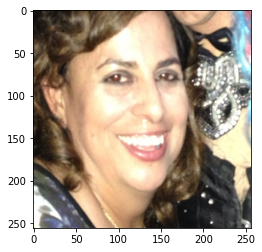

In [ ]:
# Show original image to check if the size is 256x256 as requested by the paper
img = X_train[100, :, :, :]
plt.imshow(img)

In [ ]:
# Centre crop image before feeding into network for training
# Size of the images should be 227x227 after cropping
left = int((ori_size-img_size) / 2)
top = int((ori_size-img_size) / 2)
right = int((ori_size+img_size) / 2)
bottom = int((ori_size+img_size) / 2)

X_train = X_train[:,left:right,top:bottom,:]
X_val = X_val[:,left:right,top:bottom,:]

print(X_train.shape)
print(X_val.shape)

(11406, 227, 227, 3)
(2642, 227, 227, 3)


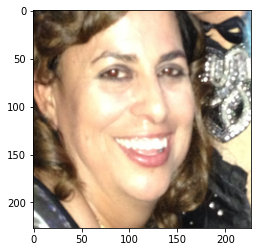

In [ ]:
# Show cropped image to check dimension
img = X_train[100, :, :, :]
plt.imshow(img)

In [ ]:
# Dataset augmentation to improve the generalization of the model
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(X_train)

# Setup learning rate scheduler
# Note that the arguments are kept constant throughout the testings
scheduler_1 = ExponentialDecay(lr1,
                               decay_steps=1000,
                               decay_rate=0.96,
                               staircase=True)

# Setup callbacks for model checkpoint and csv logger for result storing
checkpoint = ModelCheckpoint(base_path + results_prefix + f'efficient_cv_fold_{fold}_bag_{bag}.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
csv_logger = CSVLogger(base_path + results_prefix + f'efficient_cv_fold_{fold}_bag_{bag}_freezed.csv')
callbacks = [checkpoint, csv_logger]

# Compile and train model
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=scheduler_1))

model.summary()

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=epochs1,
                    verbose=1,
                    callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 8, 8, 2048)        28513520  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 28,515,569
Trainable params: 2,049
Non-trainable params: 28,513,520
_________________________________________________________________
Epoch 1/10
712/713 [============================>.] - ETA: 0s - loss: 763.9200 - accuracy: 0.5073
Epoch 00001: val_accuracy improved from -inf to 0.50530, saving model to drive/My Drive/CE4042 : Neural Network & Deep Learning/Project/resu

In [ ]:
# Unfreeze the pre-trained weights to allow training
efficient.trainable = True
        
# Setup learning rate scheduler again
scheduler_2 = ExponentialDecay(lr2,
                               decay_steps=1000,
                               decay_rate=0.96,
                               staircase=True)

# Setup callbacks again
checkpoint = ModelCheckpoint(base_path + results_prefix + f'efficient_cv_fold_{fold}_bag_{bag}.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
csv_logger = CSVLogger(base_path + results_prefix + f'efficient_cv_fold_{fold}_bag_{bag}_unfreezed.csv')
callbacks = [checkpoint, csv_logger]

# Compile and train model again
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=scheduler_2))

print()
model.summary()

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=epochs2,
                    verbose=1,
                    callbacks=callbacks)

## end


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 8, 8, 2048)        28513520  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________
Epoch 1/30
713/713 [==============================] - ETA: 0s - loss: 2.6609 - accuracy: 0.7484
Epoch 00001: val_accuracy improved from -inf to 0.87434, saving model to drive/My Drive/CE4042 : Neural Network & Deep Learning/Project/res